In [1]:
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import NUTS
from pyro.infer.mcmc import MCMC
import arviz

In [2]:
def f (x):
    return np.sin (20 * x) + 2 * np.cos (14 * x) - 2 * np.sin (6 * x)

x = torch.tensor ([-1, -0.5, 0, 0.5, 1])
#x = torch.linspace (-1, 1, 20)
y = f (x)
#x = x + torch.randn (x.shape) * 0.05
#print (x)


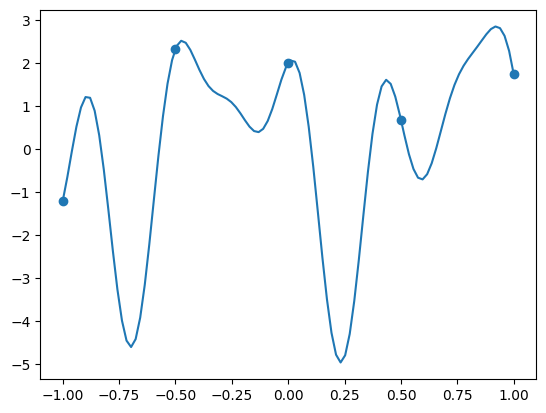

In [3]:
test_x = np.linspace (-1, 1, 100)
test_y = f (test_x)
plt.scatter (x, y)
plt.plot (test_x, test_y)
#x = torch.linspace (-1, 1, 10)
#y = torch.tensor (f (x))
#x = x + torch.randn (x.shape) * 0.05


In [4]:
def plot(
    x,
    y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(x.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-1.2, 1.2)

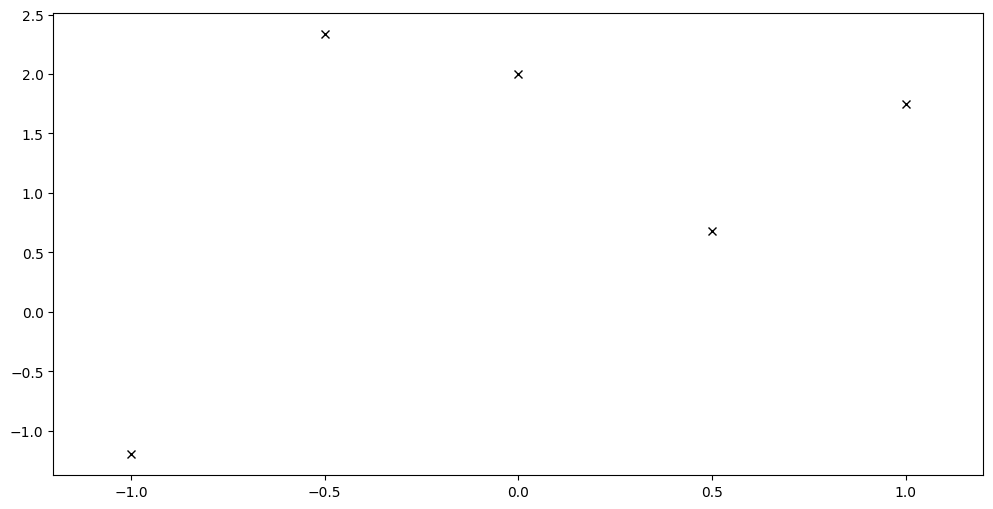

In [5]:
plot(x, y, plot_observed_data=True)

In [6]:
lengthscale = pyro.nn.PyroSample (dist.LogNormal(-1, 1))
variance = pyro.nn.PyroSample (dist.LogNormal (0, 2))
kernel = gp.kernels.RBF(
    input_dim=1#, variance=variance, lengthscale=lengthscale
)
kernel.variance = variance
kernel.lengthscale = lengthscale
#kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
#kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
gpr = gp.models.GPRegression(x, y, kernel, noise=torch.tensor(1e-4))
#plot(x, y, model=gpr, kernel=kernel, n_prior_samples=10)
#_ = plt.ylim((-8, 8))


In [7]:
#model = GP_model (x, y)
nuts_kernel = NUTS(gpr.model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=100)
mcmc.run()
samples = mcmc.get_samples()

for k, v in samples.items():
    print(k, v.shape)

Warmup [1]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

kernel.lengthscale torch.Size([1000])
kernel.variance torch.Size([1000])


c:\Program Files\Python310\lib\site-packages\torch\autograd\__init__.py:300: UserWarning: operator () profile_node %1383 : int[] = prim::profile_ivalue(%1381)
 does not have profile information (Triggered internally at ..\torch\csrc\jit\codegen\cuda\graph_fuser.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


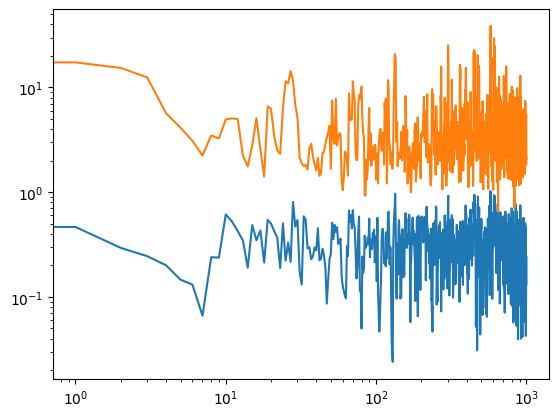

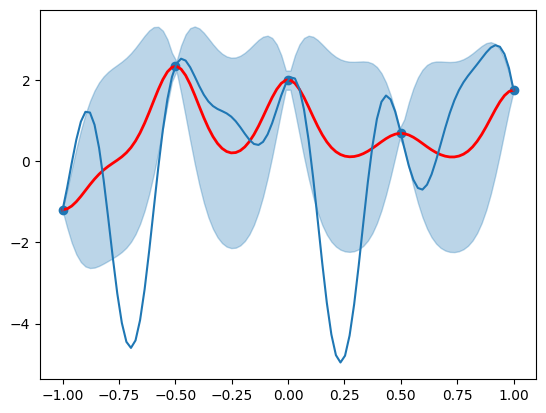

In [8]:
plt.loglog (samples['kernel.lengthscale'], label='lengthscale')
plt.loglog (samples['kernel.variance'], label='variance')
plt.show()

x_new = torch.linspace (-1, 1, 100)
mean, cov = gpr (x_new, full_cov=True, noiseless=False)
sd = cov.diag().sqrt()  # standard deviation at each input point x
plt.plot(x_new.detach().numpy(), mean.detach().numpy(), "r", lw=2)  # plot the mean
plt.fill_between(
    x_new.numpy(),  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * sd).detach().numpy(),
    (mean + 2.0 * sd).detach().numpy(),
    color="C0",
    alpha=0.3,
)
plt.scatter (x, y)
plt.plot (test_x, test_y)
plt.show()

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.330  0.178   0.039    0.634      0.011    0.008   
kernel.variance     4.612  4.342   0.708   12.486      0.335    0.239   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     285.0     341.0   1.01  
kernel.variance        251.0     162.0   1.01  


c:\Program Files\Python310\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


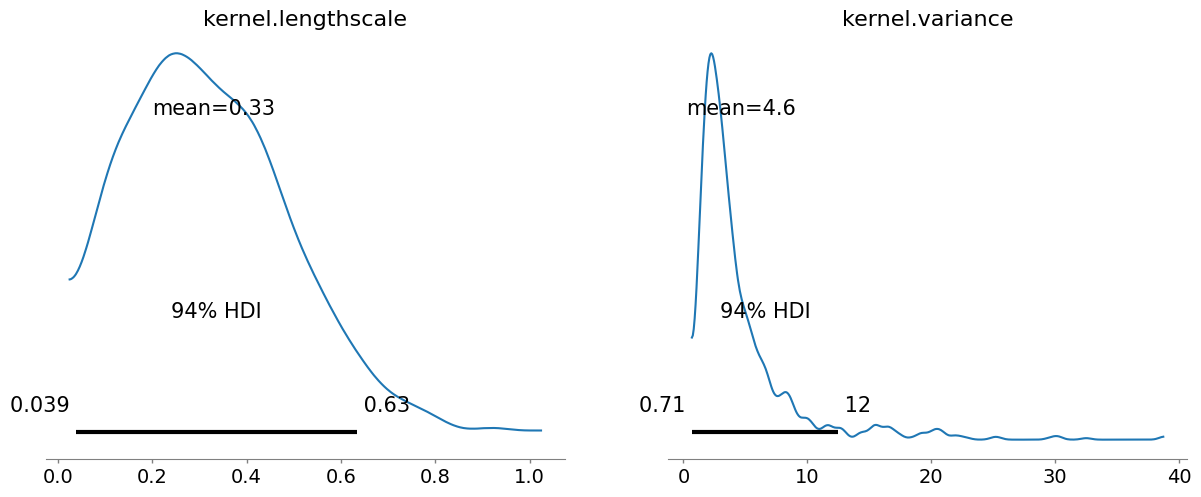

array([[<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
        <AxesSubplot: title={'center': 'kernel.lengthscale'}>],
       [<AxesSubplot: title={'center': 'kernel.variance'}>,
        <AxesSubplot: title={'center': 'kernel.variance'}>]], dtype=object)

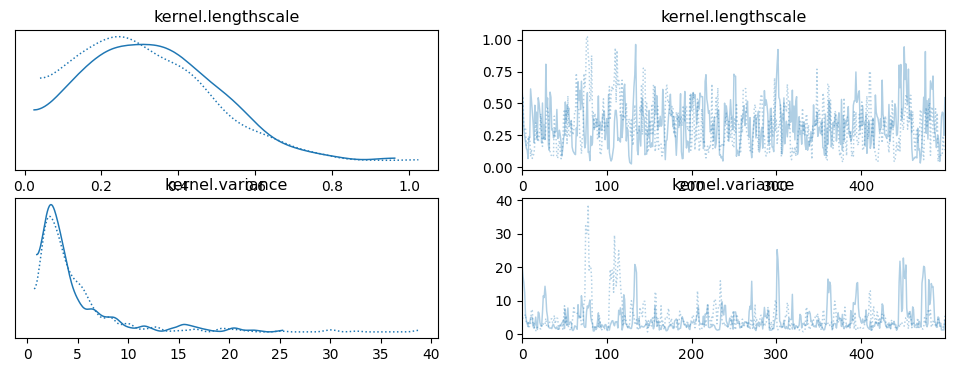

In [9]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print (summary)

arviz.plot_posterior (data, var_names=['kernel.lengthscale', 'kernel.variance'])
plt.show()
arviz.plot_trace (data, var_names=['kernel.lengthscale', 'kernel.variance'])

torch.Size([2, 5])
Iteration:  0


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

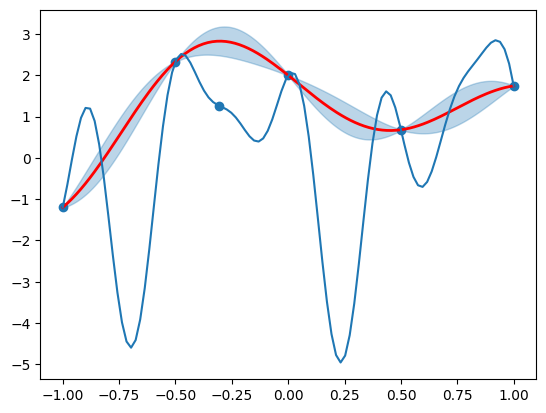

Iteration:  1


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

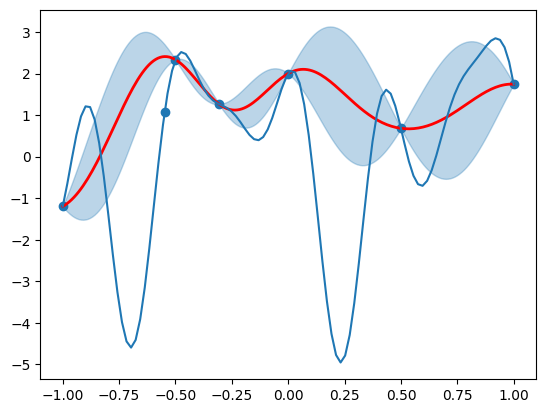

Iteration:  2


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

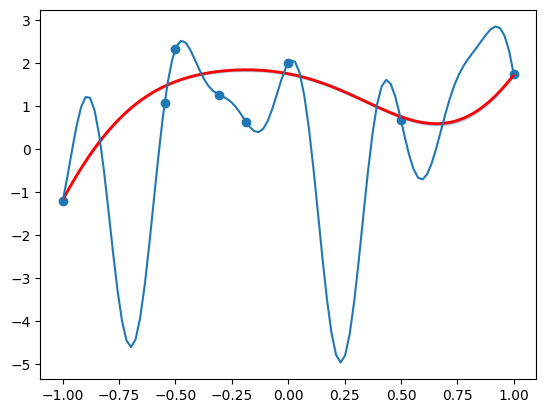

Iteration:  3


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

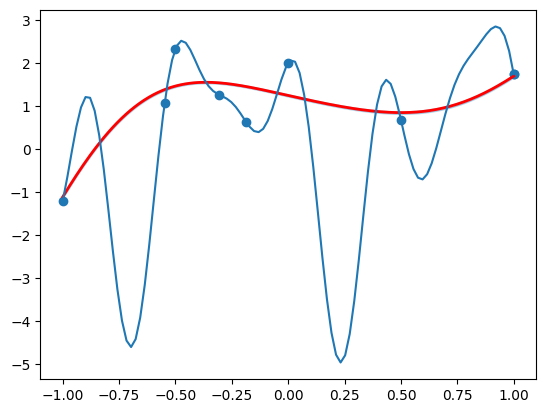

Iteration:  4


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

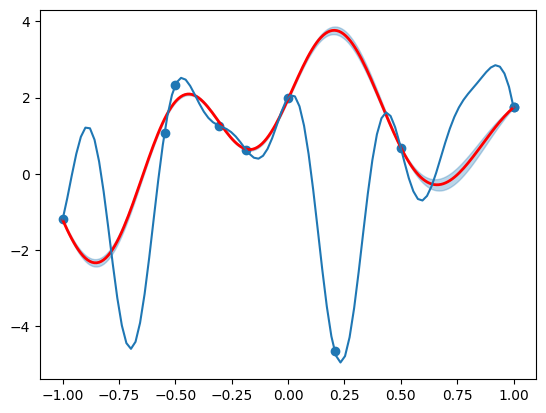

Iteration:  5


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

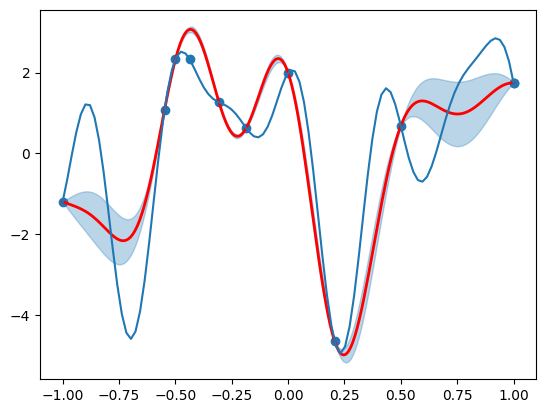

Iteration:  6


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

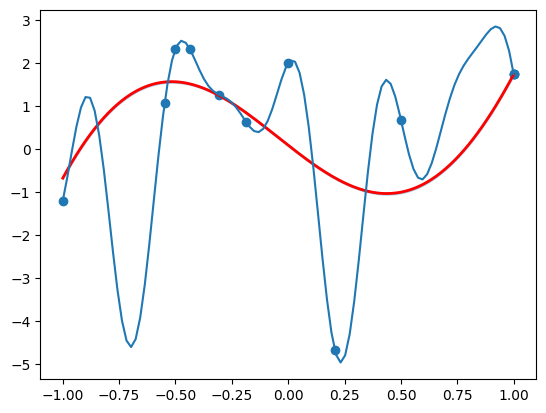

Iteration:  7


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

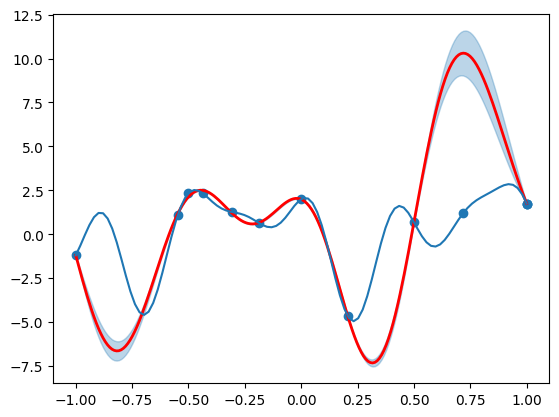

Iteration:  8


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

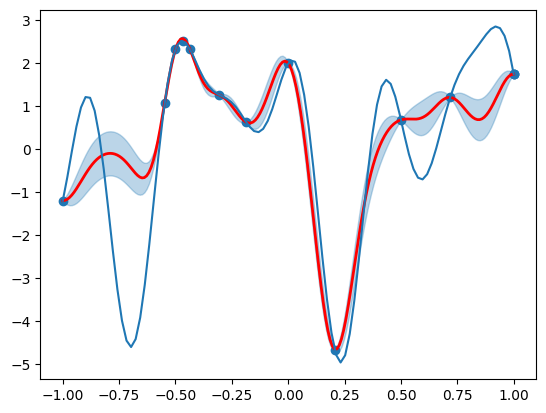

Iteration:  9


Warmup [1]:   0%|          | 0/101 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/101 [00:00, ?it/s]

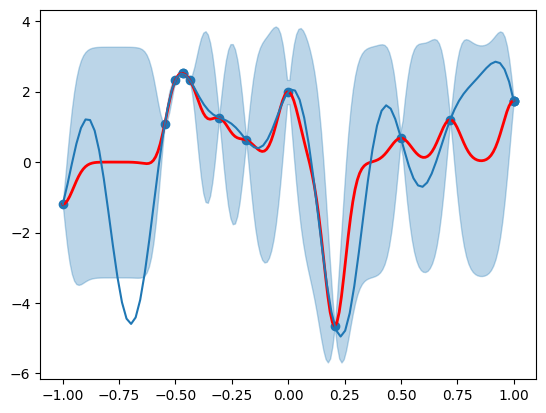

In [10]:
# Now, use the code from B.1 to build a Bayesian Optimization loop to find a local
# optimum of f. For this, implement Algorithm 1. In each iteration, sample a function
# observed on X∗
# from the posterior predictive of the GP using the dataset. Then you
# locate the minimum of the sampled function on X∗ and evaluate f at this position.
# Finally, add the new position/value pair to D. Repeat until a target number of
# iterations is reached. For the GP use the same prior parameters as in the previous
# task and you should also ensure sufficient convergence of the MCMC chain. For X∗
# use 200 evenly spaced points in [−1, 1]
# optimum of f. For this, implement Algorithm 1. In each iteration, sample a function

def bayesian_optimization (D, X_size, n_iter=10):
    X_new = torch.linspace (-1, 1, X_size)

    for k in range (n_iter):
        print ("Iteration: ", k)
        pyro.clear_param_store()
        lengthscale = pyro.nn.PyroSample (dist.LogNormal(-1, 1))
        variance = pyro.nn.PyroSample (dist.LogNormal (0, 2))
        kernel = gp.kernels.RBF(
            input_dim=1#, variance=variance, lengthscale=lengthscale
        )
        kernel.variance = variance
        kernel.lengthscale = lengthscale
        
        gpr = gp.models.GPRegression(D[0], D[1], kernel, noise=torch.tensor(1e-4))
        nuts_kernel = NUTS(gpr.model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
        mcmc = MCMC(nuts_kernel, num_samples=1, num_chains=2, warmup_steps=20)
        mcmc.run()
        samples = mcmc.get_samples()

        mean, cov = gpr (X_new, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt() 

        x_p = X_new [torch.argmin (mean)]
        epsilon = 1e-1
        distances = torch.abs (X_new - x_p)
        if torch.min (distances) < epsilon:
            x_p = X_new [torch.argmax (mean)]
        y_p = f (x_p)
        D = torch.cat ((D, torch.stack ((x_p, y_p)).reshape (2, 1)), dim=1)

        plt.plot (X_new.detach().numpy(), mean.detach().numpy(), "r", lw=2)  # plot the mean
        plt.fill_between(
            X_new.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).detach().numpy(),
            (mean + 2.0 * sd).detach().numpy(),
            color="C0",
            alpha=0.3,
        )
        plt.scatter (D[0], D[1])
        plt.plot (test_x, test_y)
        plt.show ()
    return D, mean


    

D = torch.stack ((x, y))
print (D.size())
new_D, mean = bayesian_optimization (D, 200, n_iter=10)

tensor([[-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -0.3065, -0.5477, -0.1859,
          1.0000,  0.2060, -0.4372,  1.0000,  0.7186, -0.4673, -0.4673],
        [-1.1983,  2.3341,  2.0000,  0.6815,  1.7453,  1.2631,  1.0797,  0.6250,
          1.7453, -4.6532,  2.3351,  1.7453,  1.2045,  2.5175,  2.5175]])
(100,)
(100,)


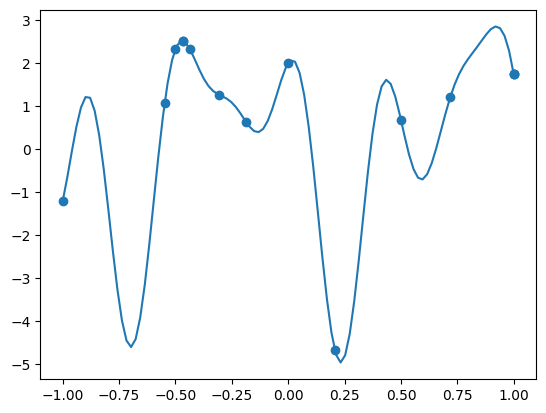

In [11]:
print (new_D)
print (test_y.shape)
print (test_x.shape)
plt.plot (test_x, test_y)
plt.scatter (new_D[0], new_D[1])
plt.show ()